In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [157]:
import os
os.system('mkdir -p images')

0

In [2]:
k_b = 0.001982923700

In [3]:
HIST_MIN = -1
HIST_MAX = 181
NUM_BINS = 61
T = 300
BIN_WIDTH = (HIST_MAX - HIST_MIN) / NUM_BINS
TOL = 0.01
kT = k_b * T
METAFILE = 'meta.dat'

In [4]:
HISTOGRAM = np.zeros(NUM_BINS, dtype = np.float32)
prob = HISTOGRAM.copy()
final_prob = HISTOGRAM.copy()
ave_p = HISTOGRAM.copy()
ave_p2 = HISTOGRAM.copy()
ave_pdf = HISTOGRAM.copy()
free_ene = HISTOGRAM.copy()


In [5]:
def get_numwindows(filename):
    fo = open(filename, "r")
    lines = fo.readlines()
    i = 0
    for line in lines:
        if line[0] == '#':
            continue
        if line.isspace():
            continue
        i += 1
    return i

In [6]:
i = get_numwindows(METAFILE)

In [7]:
def make_hist_group(num_windows):
    h = {
        "num_windows": num_windows,
        "bias_locations": np.empty(num_windows, dtype = np.float32),
        "spring_constants": np.empty(num_windows, dtype = np.float32),
        "F": np.zeros(num_windows, dtype = np.float32),
        "F_old": np.zeros(num_windows, dtype = np.float32),
        "kT": np.zeros(num_windows, dtype = np.float32),
        "partition": np.empty(num_windows, dtype = np.float32),
        "hists": [], 
    }
    return h

In [8]:
hist_group = make_hist_group(i)

In [9]:
def read_data(filename):
    global HISTOGRAM
    HISTOGRAM = np.zeros(NUM_BINS, dtype = np.float32)
    fo = open(filename, "r")
    lines = fo.readlines()
    num_points = 0
    for line in lines:
        if line[0] == '#':
            continue
        t, val = line.split()
        t, val = float(t), float(val)
        if val > HIST_MIN and val < HIST_MAX:
            index = int((val - HIST_MIN) / BIN_WIDTH)
            HISTOGRAM[index] += 1
            num_points += 1
    return num_points

In [10]:
def hist_alloc(first, last, num_points):
    hp = {
        "first" : first,
        "last" : last,
        "num_points" : num_points,
        "data" : np.zeros(last - first + 1, dtype = np.float32)
    }
    return hp

In [11]:
def read_metadata(filename, hist_group):
    fo = open(filename, "r")
    lines = fo.readlines()
    current_window = 0
    hist_group['hists'] = [None] * len(lines)
    for line in lines:
        if line[0] == '#':
            continue
        filename, loc, spring = line.split(' ')
        hist_group['bias_locations'][current_window] = loc
        hist_group['spring_constants'][current_window] = spring
        
        correl_time = 1.0
        hist_group['kT'][current_window] = -1.0
        
        num_points = read_data(filename)
        tmp = np.where(HISTOGRAM != 0)[0]
        min_nonzero = tmp.min()
        max_nonzero = tmp.max()
        assert min_nonzero <= max_nonzero, "No data points within histogram bounds"
        h = hist_alloc(min_nonzero, max_nonzero, num_points)
        for j in range(min_nonzero, max_nonzero + 1):
            h['data'][j - min_nonzero] = HISTOGRAM[j]
        
        hist_group['hists'][current_window] = h
        
        s = hist_group['hists'][current_window]['data'].sum()
        hist_group['hists'][current_window]['cum'] = \
            hist_group['hists'][current_window]['data'].cumsum()
        
        hist_group['hists'][current_window]['cum'] /= s
        if num_points < 0:
            print("Error reading data file!")
        current_window += 1
    return current_window

In [12]:
k = read_metadata(METAFILE, hist_group)

assert k == hist_group['num_windows']

hist_group['kT'][:] = kT

final_f = np.zeros(hist_group['num_windows'], dtype = np.float32)

hist_group['F'][:] = 0
hist_group['F_old'][:] = 0

In [13]:
def is_converged(h):
    error = np.abs(h['F'] - h['F_old'])
    if (error > TOL).any():
        return 0
    return error.size

In [14]:
def save_free(h):
    h['F_old'][:] = h['F']
    h['F'][:] = 0

In [15]:
def calc_coor(i):
    return HIST_MIN + (i + 0.5) * BIN_WIDTH
    
def get_histval(hist, index):
    if index < hist['first'] or index > hist['last']:
        return 0
    return hist['data'][index - hist['first']]

def calc_bias(h, index, coor):
    spring = h['spring_constants'][index]
    loc = h['bias_locations'][index]
    dx = coor - loc
    dx = np.abs(dx)
    return 0.5 * dx * dx * spring

In [16]:
def wham_iteration(h, prob):
    
    for i in range(NUM_BINS):
        coor = calc_coor(i)
        num = 0.0
        denom = 0.0
        
        for j in range(h['num_windows']):
            num += get_histval(h['hists'][j], i)
            bias = calc_bias(h, j, coor)
            bf = np.exp((h['F_old'][j] - bias) / h['kT'][j])
            denom += h['hists'][j]['num_points'] * bf
            
        prob[i] = num / denom
        
        for j in range(h['num_windows']):
            bias = calc_bias(h, j, coor)
            bf = np.exp(-bias / h['kT'][j]) * prob[i]
            h['F'][j] += bf
#             print(i, j, bias, bf, h['F'][j], h['kT'][j])
            
#         print((h['F'] == 0).all())
#     Take natural logarithm of Eq 9 
    for j in range(h['num_windows']):
        h['F'][j] = -h['kT'][j] * np.log(h['F'][j])
    for j in reversed(range(h['num_windows'])):
        h['F'][j] -= h['F'][0]

In [17]:
def average_diff(hist_group):
    error = np.abs(hist_group['F'] - hist_group['F_old']).sum()
    return error / hist_group['num_windows']

def calc_free(free_ene, prob, kT):
    free_ene[:] = -kT * np.log(prob)
    bin_min = np.argmin(free_ene)
    free_ene[:] -= free_ene[bin_min]
    return bin_min

In [18]:
max_iteration = 10000
first = 1

In [19]:
i = get_numwindows(METAFILE)
hist_group = make_hist_group(i)

k = read_metadata(METAFILE, hist_group)

assert k == hist_group['num_windows']

hist_group['kT'][:] = kT

final_f = np.zeros(hist_group['num_windows'], dtype = np.float32)

hist_group['F'][:] = 0
hist_group['F_old'][:] = 0
first = 1
iteration = 0

In [20]:
while (not is_converged(hist_group) or first):
    first = 0
    save_free(hist_group)
    wham_iteration(hist_group, prob)
#     print(prob)
    iteration += 1
#     if iteration > 1:
#         break
    if iteration % 100 == 0:
        error = average_diff(hist_group)
#         print("Iteration {}: {}".format(iteration, error))
    if iteration % 100 == 0:
        calc_free(free_ene, prob, kT)
        for i in range(NUM_BINS):
            coor = calc_coor(i)
#             print("{} {} {}".format(coor, free_ene[i], prob[i]))
        
#         print("# Dumping simulation biases, in the metadata file order \n")
#         print("# Window F (free energy units)")
        for j in range(hist_group['num_windows']):
#             print("# {} {}".format(j, hist_group['F'][j]))
            final_f[j] = hist_group['F'][j]
    if iteration >= max_iteration:
        print("Too many iterations: {}".format(iteration))
        break

In [21]:
print(iteration)

278


In [22]:
print("# Dumping simulation biases, in the metadata file order \n")
print("# Window F (free energy units)")
for j in range(hist_group['num_windows']):
        print("# {} {}".format(j, hist_group['F'][j]))
        final_f[j] = hist_group['F'][j]

# Dumping simulation biases, in the metadata file order 

# Window F (free energy units)
# 0 0.0
# 1 -0.16396020352840424
# 2 -0.04462217912077904
# 3 0.14028258621692657
# 4 0.31599313020706177
# 5 0.5003530383110046
# 6 0.7310488820075989
# 7 1.0045722723007202
# 8 1.3155680894851685
# 9 1.6269413232803345
# 10 1.9325437545776367
# 11 2.260859489440918
# 12 2.6139917373657227
# 13 2.992504358291626
# 14 3.3920114040374756
# 15 3.8038079738616943
# 16 4.222769737243652
# 17 4.6706624031066895
# 18 5.162755966186523
# 19 5.6953511238098145
# 20 6.276191711425781
# 21 6.8847784996032715
# 22 7.502377510070801
# 23 8.127459526062012
# 24 8.732381820678711
# 25 9.343092918395996
# 26 9.95725154876709
# 27 10.410977363586426
# 28 10.323213577270508
# 29 9.820300102233887
# 30 9.252104759216309
# 31 8.683116912841797
# 32 8.101648330688477
# 33 7.528109550476074
# 34 6.974527359008789
# 35 6.4231858253479
# 36 5.871573448181152
# 37 5.320510387420654
# 38 4.745107650756836
# 39 4.1523156166

In [23]:
bin_min = calc_free(free_ene, prob, kT)

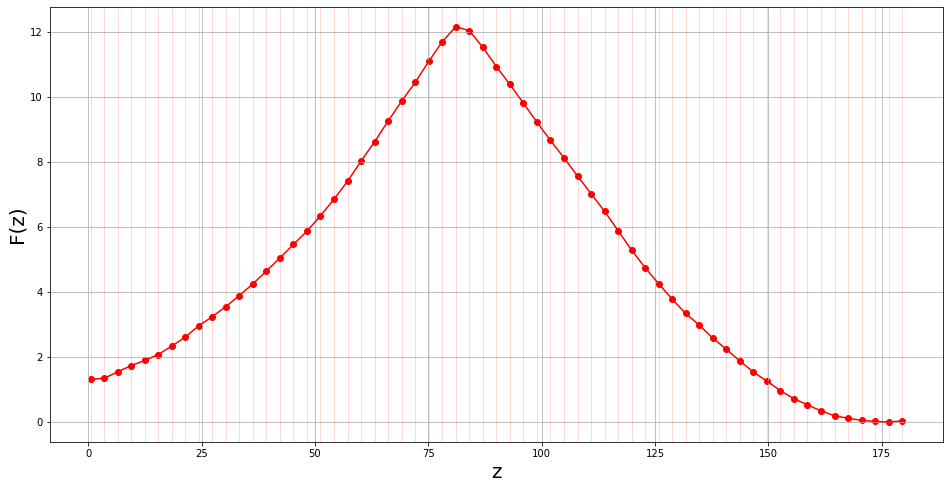

In [158]:
fig = plt.figure(figsize = (16, 8))
coor = list(map(lambda i: calc_coor(i), np.arange(NUM_BINS)))
J = hist_group['num_windows']
for i in range(J):
    plt.axvline(coor[i], alpha = 0.3, linewidth = 0.5)
plt.plot(coor, free_ene)
plt.scatter(coor, free_ene)
plt.xlabel(r"z", fontsize = 20)
plt.ylabel(r"F(z)", fontsize = 20)
plt.grid(True)
plt.savefig("images/Free_energy.png")

## Figures for more clarity

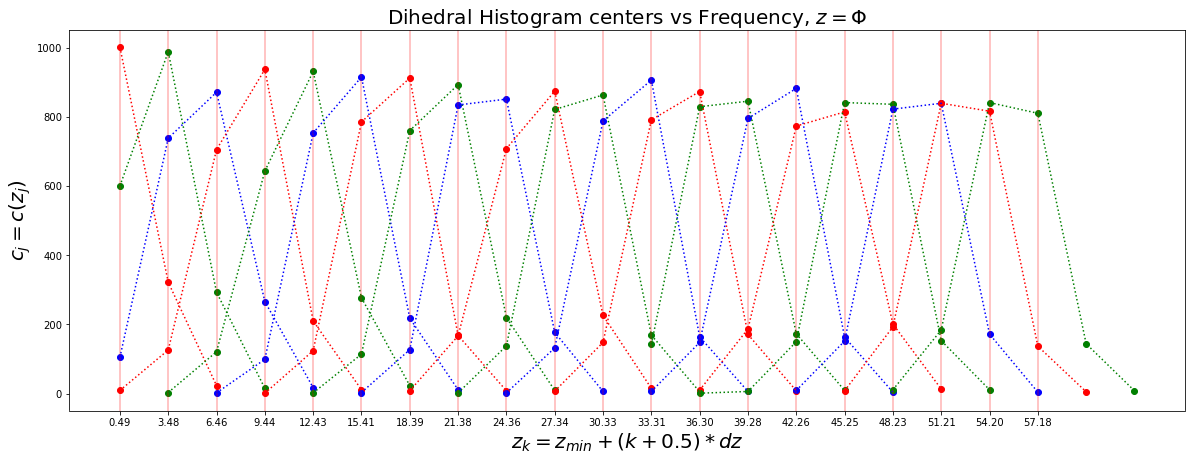

In [159]:
fig = plt.figure(figsize = (20, 7))
from cycler import cycler

n = 20
# new_colors = [plt.get_cmap('gist_rainbow')(1. * i/n) for i in range(n)]
# custom_cycler = cycler('color', new_colors) + 
#                    cycler('linestyle', [':'] * n)

# custom_cycler = (cycler(color=['r', 'g', 'b']) +
#                   cycler(linestyle=['-', '--', ':']))

custom_cycler = (cycler(color=['r', 'g', 'b']) +
                  cycler(linestyle=[':']*3))

plt.rc('axes', 
       prop_cycle=custom_cycler)
# x = np.linspace(0, 1, 100)

# for i in range(4):
#     plt.plot([_ + i for _ in x])
centers = list(map(calc_coor, np.arange(n)))

for i in range(n):
    first = hist_group['hists'][i]['first']
    last = hist_group['hists'][i]['last']
    data = hist_group['hists'][i]['data']
    p = list(map(calc_coor, list(range(first, last + 1))))
    plt.axvline(x = centers[i], alpha = 0.3)    
    plt.scatter(p, data)
    plt.plot(p, data)
ticks = plt.xticks(centers)
j = plt.title(r'Dihedral Histogram centers vs Frequency, $ z = \Phi$', fontsize = 20)
h = plt.xlabel(r'$z_k = z_{min} + (k + 0.5) * dz $', fontsize = 20)
g = plt.ylabel(r'$ c_j = c(z_j)$', fontsize = 20)
plt.savefig("images/Histograms.png")

In [26]:
print('Visual representation of a set of histograms for the first 60 simulations. \
      Each connected colored line represents a histogram for one simulation. The vertical lines represent the centers \
      of the histogram bins.')

Visual representation of a set of histograms for the first 60 simulations.       Each connected colored line represents a histogram for one simulation. The vertical lines represent the centers       of the histogram bins.


In [27]:
tmp = np.empty_like(HISTOGRAM)
J = hist_group['num_windows']
n = J
c = np.empty((n, NUM_BINS))

for i in range(n):
    first = hist_group['hists'][i]['first']
    last = hist_group['hists'][i]['last']
    data = hist_group['hists'][i]['data']
    tmp[:] = 0
    tmp[first:last + 1] = data
    c[i] = tmp

In [28]:
c.shape

(61, 61)

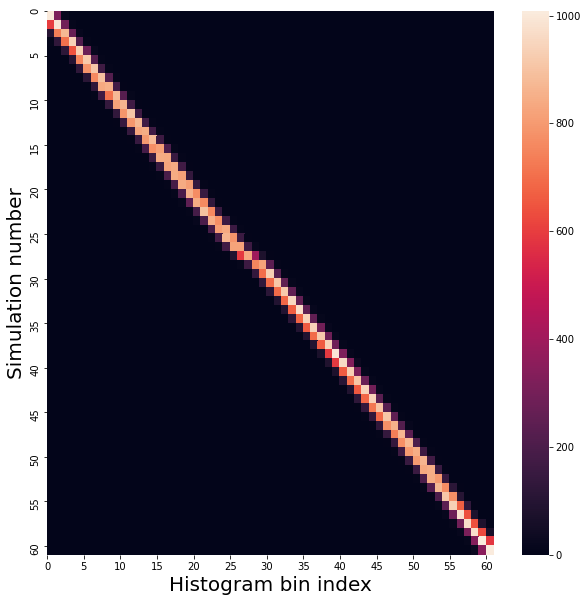

In [160]:
import seaborn as sns
fig = plt.figure(figsize = (10, 10))
ticks = list(range(0, 65, 5))
ax = sns.heatmap(c)
h = ax.xaxis.set_ticks(ticks)
y = ax.xaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))
h = ax.yaxis.set_ticks(ticks)
y = ax.yaxis.set_major_formatter(ticker.FormatStrFormatter('%d'))

ax.set_xlabel("Histogram bin index", fontsize = 20)
ax.set_ylabel("Simulation number", fontsize = 20)
plt.savefig("images/c_matrix.png")
# plt.imshow(c, interpolation='bilinear', cmap=cm.Greys_r)

In [30]:
print("A heatmap of the matrix c = [c_jk] where c_jk represents the number of observations falling in the kth \
      histogram bin for the jth simulation.")

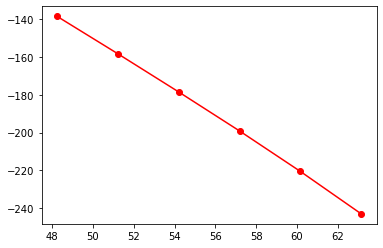

In [112]:
j = 0
first = hist_group['hists'][i]['first']
last = hist_group['hists'][i]['last']
coor_values = list(map(calc_coor, np.arange(first, last + 1)))
n_j = list(map(lambda z : - (1 / hist_group['kT'][j]) * calc_bias(hist_group, j, z), coor_values))
coor_values = np.array(coor_values)
n_j = np.array(n_j)
p_jw = hist_group['hists'][i]['cum']
kT = hist_group['kT'][j]
F = - kT * np.log(p_jw) + kT * n_j

plt.plot(coor_values, F)
plt.scatter(coor_values, F)

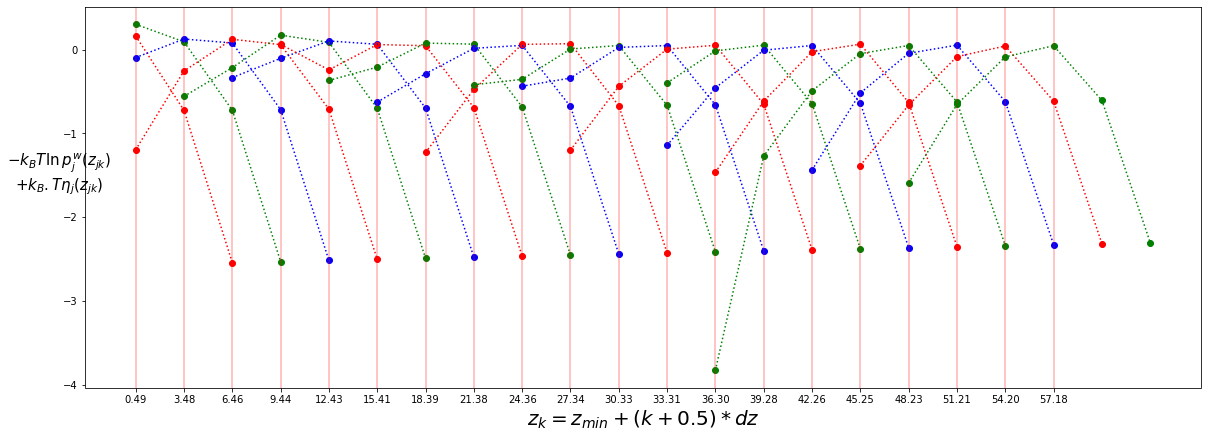

In [161]:
fig = plt.figure(figsize = (20, 7))
n = 20
for j in range(n):
    first = hist_group['hists'][j]['first']
    last = hist_group['hists'][j]['last']
    coor_values = list(map(calc_coor, np.arange(first, last + 1)))
    kT = hist_group['kT'][j]
    n_j = list(map(lambda z : - (1 / kT) * calc_bias(hist_group, j, z), coor_values))
    coor_values = np.array(coor_values)
    n_j = np.array(n_j)
    p_jw = hist_group['hists'][j]['cum']
    F = - kT * np.log(p_jw) + kT * n_j
    plt.axvline(x = centers[j], alpha = 0.3)    
    plt.plot(coor_values, F)
    plt.scatter(coor_values, F)
ticks = plt.xticks(centers)
h = plt.xlabel(r'$z_k = z_{min} + (k + 0.5) * dz $', fontsize = 20)
g = plt.ylabel(r"$-k_BT \ln{\: p_j^w(z_{jk})}$"
               "\n"
               r"$+ k_B.T\eta_j(z_{jk})$", fontsize = 15)
g.set_rotation(0)
plt.savefig("images/F_z.png")

In [109]:
cycle = (cycler(color=['r', 'g', 'b']) +
                  cycler(linestyle=['-']*3))

plt.rc('axes', 
       prop_cycle=cycle)